In [2]:
import os
import sys

sys.path.append('../')
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.9'

In [3]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

import jax_cosmo as jc

from jax.experimental.ode import odeint
from jaxpm.painting import cic_paint, cic_paint_2d
from jaxpm.pm import linear_field, lpt, make_ode_fn
from jaxpm.lensing import density_plane

import jax_cosmo.constants as constants

from jax.scipy.ndimage import map_coordinates
from jaxpm.utils import gaussian_smoothing

import astropy.units as u

In [4]:
# Below are a few parameters that generate a low resolution version of the k-TNG simulation

box_size = [200.,200.,4000.]    # Transverse comoving size of the simulation volume
nc = [64, 64, 320]              # Number of transverse voxels in the simulation volume
lensplane_width = 62.5         # Width of each lensplane
# lensplane_width = 3.125         # Width of each lensplane
field_size = 5                  # Size of the lensing field in degrees
field_npix = 128                # Number of pixels in the lensing field
z_source = jnp.linspace(0,2)    # Source planes

# Defining the coordinate grid for lensing map
xgrid, ygrid = jnp.meshgrid(jnp.linspace(0, field_size, field_npix, endpoint=False), # range of X coordinates
                           jnp.linspace(0, field_size, field_npix, endpoint=False)) # range of Y coordinates

coords = jnp.stack([xgrid, ygrid], axis=0)*u.deg
c = coords.reshape([2, -1]).T.to(u.rad)

# Cosmology 
cosmology = jc.Planck15(Omega_c=0.2589, sigma8=0.8159)

In [5]:
lensplanes = jnp.load('../data/lensplanes.npy', allow_pickle=True)

In [6]:
get_planes = lambda lensplanes: jnp.stack([plane['plane'] for plane in lensplanes], axis=-1)

planes = get_planes(lensplanes)
print(planes.shape)

(64, 64, 64)


In [7]:
def get_norm_factor(lensplanes): 
    dz = jnp.array([plane['dz'] for plane in lensplanes])
    r = jnp.array([plane['r'] for plane in lensplanes])
    a = jnp.array([plane['a'] for plane in lensplanes])
    return dz * r / a

norm_factor = get_norm_factor(lensplanes)

def get_coords_cart(coords, lensplanes): 
    dx = jnp.array([plane['dx'] for plane in lensplanes]).reshape(1, 1, 1, -1)
    r = jnp.array([plane['r'] for plane in lensplanes]).reshape(1, 1, 1, -1)

    return coords[..., None] * r / dx - 0.5
    # dx = [plane['dx'] for plane in lensplanes]
    # r = [plane['r'] for plane in lensplanes]
    # return [coords * r[i] / dx[i] - 0.5 for i in range(len(lensplanes))]

coords_cart = get_coords_cart(jnp.array(c).T.reshape(2,field_npix,field_npix), lensplanes)

In [8]:
get_const_factor = lambda cosmo: 3 / 2 * cosmo.Omega_m * (constants.H0 / constants.c)**2

def get_planes_norm(planes, mean_od, norm_factor): 
  od = planes - mean_od
  print(od.shape)
  print(norm_factor.shape)
  return od * norm_factor.reshape(1, 1, -1)

def get_planes_norm_2(planes, norm_factor):
  return [(planes[..., i] - planes[..., i].mean()) * norm_factor[i] for i in range(len(planes))]

const_factor = get_const_factor(cosmology)
mean_od = jnp.mean(planes, axis=(0,1), keepdims=True)
planes_norm = get_planes_norm(planes, mean_od, norm_factor)
# planes_norm_2 = get_planes_norm_2(planes, norm_factor)

(64, 64, 64)
(64,)


In [9]:
# print(jnp.all(jnp.equal(planes_norm, jnp.stack(planes_norm_2, axis=-1))))
# print(jnp.allclose(planes_norm, jnp.stack(planes_norm_2, axis=-1)))

In [10]:
def get_source_scales(cosmo, r, z_source): 
    # Compute comoving distance of source galaxies
    r_s = jc.background.radial_comoving_distance(cosmo, 1 / (1 + z_source))
    return jnp.clip(1. - (r.reshape(1, -1) / r_s.reshape(-1, 1)), 0, 1000).reshape([-1, 1, 1, len(r)]), r_s

def get_source_scales_2(cosmo, dz, r, a, z_source):
    const_factor = 3 / 2 * cosmo.Omega_m * (constants.H0 / constants.c)**2
    norm_factor = dz * r / a
    r_s = jc.background.radial_comoving_distance(cosmo, 1 / (1 + z_source))
    source_scales = jnp.clip(1. - (r.reshape(1, -1) / r_s.reshape(-1, 1)), 0, 1000).reshape([-1, 1, 1, len(r)])
    print(norm_factor.shape)
    print(source_scales.shape)
    return const_factor * norm_factor.reshape((1, 1, 1, -1)) * source_scales

r = jnp.array([plane['r'] for plane in lensplanes])
print(r.shape)
print(z_source.shape)

source_scales, r_s = get_source_scales(cosmology, r, z_source)
print(source_scales.shape)

dz = jnp.array([plane['dz'] for plane in lensplanes])
a = jnp.array([plane['a'] for plane in lensplanes])
source_scales_2 = get_source_scales_2(cosmology, dz, r, a, z_source)

(64,)
(50,)
(50, 1, 1, 64)
(64,)
(50, 1, 1, 64)


In [11]:
jnp.array(c).T.reshape(2,field_npix,field_npix).shape

(2, 128, 128)

In [12]:
def convergence_Born(cosmo,
                     density_planes,
                     coords,
                     z_source):
  """
  Compute the Born convergence
  Args:
    cosmo: `Cosmology`, cosmology object.
    density_planes: list of dictionaries (r, a, density_plane, dx, dz), lens planes to use 
    coords: a 3-D array of angular coordinates in radians of N points with shape [batch, N, 2].
    z_source: 1-D `Tensor` of source redshifts with shape [Nz] .
    name: `string`, name of the operation.
  Returns:
    `Tensor` of shape [batch_size, N, Nz], of convergence values.
  """
  # Compute constant prefactor:
  constant_factor = 3 / 2 * cosmo.Omega_m * (constants.H0 / constants.c)**2
  # Compute comoving distance of source galaxies
  r_s = jc.background.radial_comoving_distance(cosmo, 1 / (1 + z_source))

  convergence = 0

  for entry in density_planes:
    r = entry['r']; a = entry['a']; p = entry['plane']
    dx = entry['dx']; dz = entry['dz']
    # Normalize density planes
    density_normalization = dz * r / a
    p = (p - p.mean()) * constant_factor * density_normalization
    # print(p.shape)
    # Interpolate at the density plane coordinates
    im = map_coordinates(p, 
                         coords * r / dx - 0.5, 
                         order=1, mode="wrap")
    convergence += im * jnp.expand_dims(jnp.clip(1. - (r / r_s), 0, 1000), axis=jnp.arange(1, 1 + len(im.shape)))

  return convergence, r_s

In [13]:
def convergence_Born_2(planes_norm,
                       const_factor, 
                       coords_cart,
                       source_scales):

  convergence = 0
  ims = []
  ps = []
  for i in range(planes_norm.shape[-1]):
    p = planes_norm[..., i] * const_factor

    # Interpolate at the density plane coordinates
    im = map_coordinates(p, 
                         coords_cart[..., i], 
                         order=1, mode="wrap")

    convergence += im * source_scales[..., i]
    ims.append(im)
    ps.append(p)

  return convergence, ims, ps

In [14]:
def convergence_Born_4(planes,
                       coords_cart,
                       source_scales_2):

  convergence = 0
  ims = []
  ps = []
  for i in range(planes.shape[-1]):
    p = planes[..., i]
    p = p - p.mean()
    # Interpolate at the density plane coordinates
    im = map_coordinates(p, 
                         coords_cart[..., i], 
                         order=1, mode="wrap")

    convergence += im * source_scales_2[..., i]
    ims.append(im)
    ps.append(p)

  return convergence, ims, ps

In [15]:
print(planes.shape)
print(norm_factor.shape)

print(planes_norm.shape)
# print(const_factor.shape)
print(coords_cart.shape)
print(source_scales.shape)

(64, 64, 64)
(64,)
(64, 64, 64)
(2, 128, 128, 64)
(50, 1, 1, 64)


In [16]:
def convergence_Born_single(planes_norm,
                       const_factor, 
                       coords_cart,
                       source_scales):

  p = planes_norm * const_factor

  # Interpolate at the density plane coordinates
  im = map_coordinates(p, 
                        coords_cart, 
                        order=1, mode="wrap")

  convergence = im * source_scales

  return convergence

convergence_Born_3 = jax.vmap(convergence_Born_single, in_axes=(-1, None, -1, -1))

In [17]:
m, r_s = convergence_Born(cosmology, 
                        lensplanes,
                        coords=jnp.array(c).T.reshape(2,field_npix,field_npix),
                        z_source=z_source)

In [18]:
m.shape

(50, 128, 128)

In [27]:
from jax_lensing.inversion import ks93inv

bm = jnp.zeros((128, 128))
e1, e2 = ks93inv(m[-1], bm)

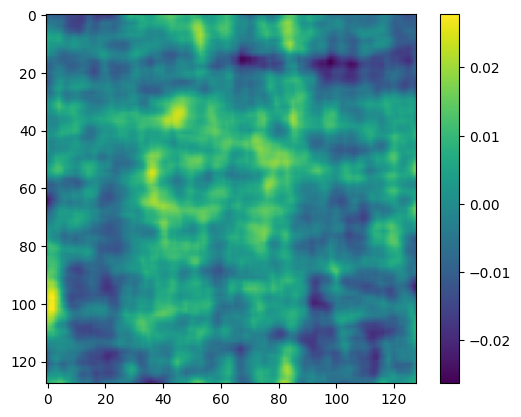

In [28]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
heatmap = ax.imshow(e1)
plt.colorbar(heatmap)
plt.show()

In [45]:
coords_init = jnp.array(c).T.reshape(2,field_npix,field_npix)
print(coords_init.shape)

(2, 128, 128)


In [49]:
coords_test = coords_init.reshape(2, -1)
m6, r_s6 = convergence_Born(cosmology, 
                        lensplanes,
                        coords=coords_init.reshape(2, -1)[:, 0],
                        z_source=z_source)

()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)
()
(50,)


In [50]:
m6.shape

(50,)

In [17]:
m2, ims2, ps2 = convergence_Born_2(planes_norm, const_factor, coords_cart, source_scales)

In [25]:
m4, ims4, ps4 = convergence_Born_4(planes, coords_cart, source_scales_2)

In [26]:
print(m2.shape)
print(m4.shape)
print(jnp.allclose(m2, m4))

(50, 128, 128)
(50, 128, 128)
True


In [23]:
print(m2[10, 10])
print(m4[10, 10])

[ 8.95192347e-04  8.85087152e-04  8.74981958e-04  8.50227314e-04
  8.50015478e-04  8.98562750e-04  9.36709620e-04  9.83299724e-04
  1.08905382e-03  1.17183416e-03  1.25702623e-03  1.34505444e-03
  1.42486570e-03  1.50865378e-03  1.65249553e-03  1.79439609e-03
  1.92125163e-03  2.01130265e-03  2.06690551e-03  2.11104381e-03
  2.08717730e-03  2.04623419e-03  2.02383330e-03  2.00331460e-03
  1.99856192e-03  1.92517860e-03  1.79635854e-03  1.68636530e-03
  1.54477017e-03  1.39011168e-03  1.25251172e-03  1.24409490e-03
  1.28231796e-03  1.23494296e-03  1.15518172e-03  1.05980680e-03
  9.22733670e-04  7.65448173e-04  6.14392583e-04  5.03179436e-04
  3.61967860e-04  2.86030327e-04  3.20994600e-04  3.71601139e-04
  4.55883568e-04  5.01157949e-04  5.85397099e-04  6.76783105e-04
  7.66072397e-04  8.52412049e-04  9.44521090e-04  1.09739815e-03
  1.19846605e-03  1.16745313e-03  1.14360163e-03  1.08433930e-03
  1.00240955e-03  8.65974240e-04  7.43168261e-04  5.66660984e-04
  3.28407103e-04  6.27067

In [23]:
m3 = convergence_Born_3(planes_norm, const_factor, coords_cart, source_scales)
print(m3.shape)
m3 = m3.sum(0)

(64, 50, 128, 128)


In [24]:
print(m2.shape)
print(m3.shape)
print(jnp.allclose(m2, m3))

(50, 128, 128)
(50, 128, 128)
True


In [22]:
print(m2[10, 10])
print(m3[10, 10])

[ 8.95192347e-04  8.85087152e-04  8.74981958e-04  8.50227314e-04
  8.50015478e-04  8.98562750e-04  9.36709620e-04  9.83299724e-04
  1.08905382e-03  1.17183416e-03  1.25702623e-03  1.34505444e-03
  1.42486570e-03  1.50865378e-03  1.65249553e-03  1.79439609e-03
  1.92125163e-03  2.01130265e-03  2.06690551e-03  2.11104381e-03
  2.08717730e-03  2.04623419e-03  2.02383330e-03  2.00331460e-03
  1.99856192e-03  1.92517860e-03  1.79635854e-03  1.68636530e-03
  1.54477017e-03  1.39011168e-03  1.25251172e-03  1.24409490e-03
  1.28231796e-03  1.23494296e-03  1.15518172e-03  1.05980680e-03
  9.22733670e-04  7.65448173e-04  6.14392583e-04  5.03179436e-04
  3.61967860e-04  2.86030327e-04  3.20994600e-04  3.71601139e-04
  4.55883568e-04  5.01157949e-04  5.85397099e-04  6.76783105e-04
  7.66072397e-04  8.52412049e-04  9.44521090e-04  1.09739815e-03
  1.19846605e-03  1.16745313e-03  1.14360163e-03  1.08433930e-03
  1.00240955e-03  8.65974240e-04  7.43168261e-04  5.66660984e-04
  3.28407103e-04  6.27067

In [106]:
# Check if equal
print(m.shape)
print(m2.shape)
print(jnp.all(jnp.equal(m, m2)))
print(jnp.allclose(m, m2))

print(m[10, 10])
print(m2[10, 10])

(50, 128, 128)
(50, 128, 128)
False
True
[ 8.95192347e-04  8.85087152e-04  8.74981958e-04  8.50227314e-04
  8.50015478e-04  8.98562750e-04  9.36709620e-04  9.83299724e-04
  1.08905382e-03  1.17183416e-03  1.25702623e-03  1.34505444e-03
  1.42486570e-03  1.50865378e-03  1.65249553e-03  1.79439609e-03
  1.92125163e-03  2.01130265e-03  2.06690551e-03  2.11104381e-03
  2.08717730e-03  2.04623419e-03  2.02383330e-03  2.00331460e-03
  1.99856192e-03  1.92517860e-03  1.79635854e-03  1.68636530e-03
  1.54477017e-03  1.39011168e-03  1.25251172e-03  1.24409490e-03
  1.28231796e-03  1.23494296e-03  1.15518172e-03  1.05980680e-03
  9.22733670e-04  7.65448173e-04  6.14392583e-04  5.03179436e-04
  3.61967860e-04  2.86030327e-04  3.20994600e-04  3.71601139e-04
  4.55883568e-04  5.01157949e-04  5.85397099e-04  6.76783105e-04
  7.66072397e-04  8.52412049e-04  9.44521090e-04  1.09739815e-03
  1.19846605e-03  1.16745313e-03  1.14360163e-03  1.08433930e-03
  1.00240955e-03  8.65974240e-04  7.43168261e-04 

In [91]:
# Check if planes_norms equal
print(planes_norm.shape)
print(len(planes_norms))
print(planes_norms[0].shape)

print(jnp.all(jnp.equal(planes_norm, jnp.stack(planes_norms, axis=-1))))

(64, 64, 64)
64
(64, 64)
False


In [93]:
# Check if ps equal

print(jnp.all(jnp.equal(jnp.array(ps), jnp.array(ps2))))

False


In [94]:
# Check if ims equal
print(jnp.all(jnp.equal(jnp.array(ims), jnp.array(ims2))))

False


In [96]:
# Check normalization factor

print(norm_factor.shape)
print(len(density_normalizations))
print(jnp.all(jnp.equal(norm_factor, jnp.array(density_normalizations))))

(64,)
64
True


In [57]:
# Check cartesian coords

print(len(coords_carts))
print(coords_carts[0].shape)
print(coords_cart.shape)

print(jnp.all(jnp.equal(coords_cart, jnp.stack(coords_carts, axis=-1))))

64
(2, 128, 128)
(2, 128, 128, 64)
True


In [58]:
# Check source scales

print(len(source_scales_list))
print(source_scales.shape)
print(source_scales_list[0].shape)
print(jnp.all(jnp.equal(source_scales, jnp.stack(source_scales_list, axis=-1))))

64
(50, 1, 1, 64)
(50, 1, 1)
True
